In [1]:
from data_loader import load_data

train_loader, val_loader, _ = load_data()

In [1]:
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_results(activation, data_split, metric='f1', csv_path='results/experiment_results.csv', save_path=None):
    """
    Plots the specified metric against the number of blocks for different initial_filters using Seaborn with distinct colors and shaded error regions.
    
    Parameters:
    - activation (str): The activation function to filter by (e.g., 'relu', 'sigmoid').
    - data_split (tuple): The data split to filter by (e.g., (0.8, 0.1, 0.1)).
    - metric (str): The metric to plot ('f1' or 'accuracy'). Default is 'f1'.
    - csv_path (str): Path to the experiment results CSV file. Default is 'results/experiment_results.csv'.
    - save_path (str): Optional path to save the plot image. If None, the plot is not saved.
    
    The function filters the data to include only configurations with:
    - nhl_activation = activation
    - data_split = data_split
    
    It then plots the specified metric vs num_blocks with separate lines for each initial_filters, each having a distinct color and shaded regions representing the metric's standard deviation.
    """

    valid_metrics = ['f1', 'accuracy']
    if metric.lower() not in valid_metrics:
        print(f"Invalid metric '{metric}'. Please choose from {valid_metrics}.")
        return
    
    if metric.lower() == 'f1':
        y_col = 'average_f1_score'
        yerr_col = 'std_f1_score'
        y_label = 'Average F1-Score'
        metric_title = 'F1-Score'
    else:
        y_col = 'average_test_accuracy'
        yerr_col = 'std_test_accuracy'
        y_label = 'Average Test Accuracy'
        metric_title = 'Test Accuracy'
    
    if not os.path.exists(csv_path):
        print(f"CSV file not found at {csv_path}")
        return
    
    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return
    
    if df['data_split'].dtype == object:
        try:
            df['data_split'] = df['data_split'].apply(lambda x: eval(x) if isinstance(x, str) else x)
        except Exception as e:
            print(f"Error converting 'data_split' column to tuples: {e}")
            return
    
    filtered_df = df[
        (df['nhl_activation'] == activation) &
        (df['data_split'] == data_split)
    ]
    
    if filtered_df.empty:
        print(f"No data found for nhl_activation='{activation}' and data_split={data_split}")
        return
    
    sns.set(style="whitegrid")
    
    initial_filters_values = sorted(filtered_df['initial_filters'].unique())
    
    palette = sns.color_palette("tab10", n_colors=len(initial_filters_values))
    
    color_mapping = dict(zip(initial_filters_values, palette))
    
    plt.figure(figsize=(12, 8))
    
    sns.lineplot(
        data=filtered_df,
        x='num_blocks',
        y=y_col,
        hue='initial_filters',
        palette=color_mapping,
        marker='o',
        linewidth=2.5,
        errorbar=None 
    )
    
    for init_filt in initial_filters_values:
        data = filtered_df[filtered_df['initial_filters'] == init_filt].sort_values(by='num_blocks')
        
        x = data['num_blocks']
        y = data[y_col]
        yerr = data[yerr_col]
        
        if yerr.isnull().any():
            print(f"Warning: NaN values found in '{yerr_col}' for initial_filters={init_filt}. Shaded region may be incomplete.")
        
        # shaded area
        plt.fill_between(
            x,
            y - yerr,
            y + yerr,
            alpha=0.2,
            color=color_mapping[init_filt]
        )
    
    plt.xlabel('Number of Blocks', fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.title(f'{metric_title} vs Number of Blocks for Different Initial Filters\n({activation.capitalize()} Activation, Data Split: {data_split})', fontsize=16)
    
    plt.xticks(sorted(filtered_df['num_blocks'].unique()))
    plt.legend(title='Initial Filters', title_fontsize=12, fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    
    if save_path:
        try:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Plot saved to {save_path}")
        except Exception as e:
            print(f"Error saving plot to '{save_path}': {e}")
    
    plt.show()

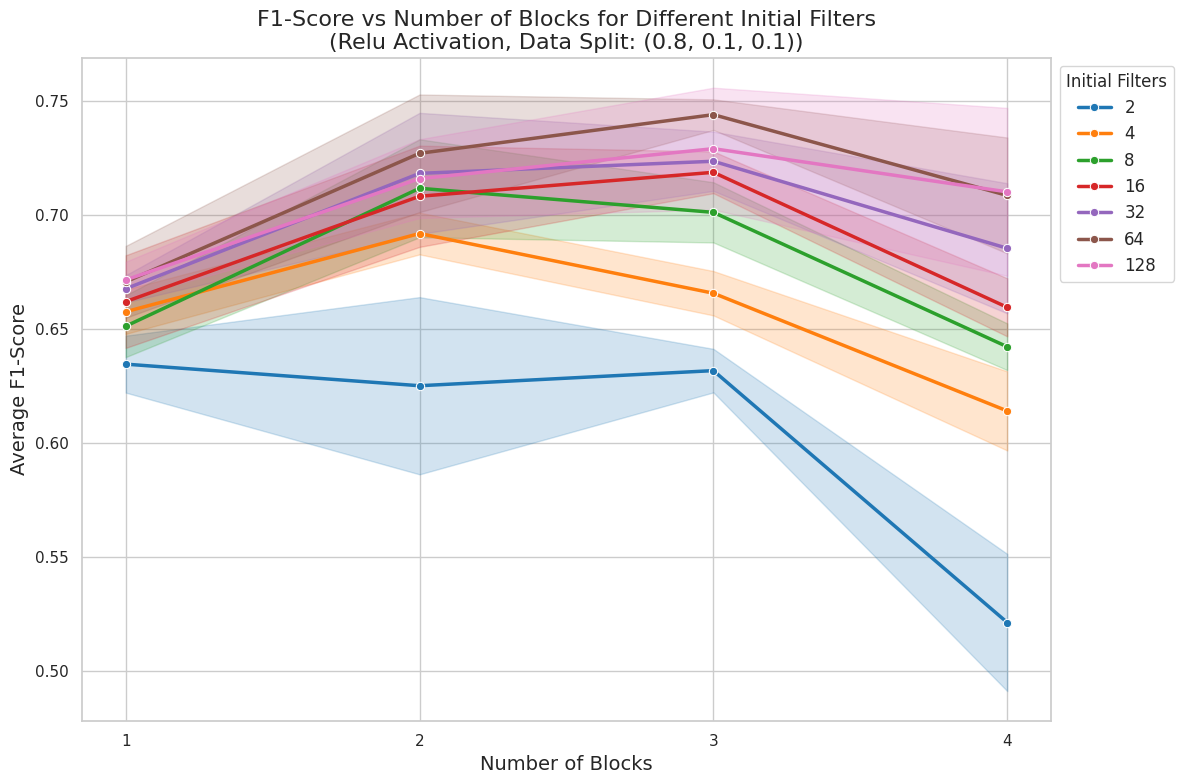

In [2]:
plot_results(
    activation  ='relu',
    data_split  =(0.8, 0.1, 0.1),
    metric      = 'f1' 
    
)

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

def plot_all(metric='accuracy', csv_path='results/experiment_results.csv', save_path=None, sharey=False):
    """
    Generates a 2-row by 3-column grid of plots visualizing the mean Test Accuracy or F1-Score across different configurations.
    
    - Rows:
        - Row 1: 'relu' activation
        - Row 2: 'sigmoid' activation
    - Columns:
        - Column 1: Data Split (0.8, 0.1, 0.1)
        - Column 2: Data Split (0.4, 0.2, 0.4)
        - Column 3: Data Split (0.1, 0.1, 0.8)
    
    Each subplot displays:
        - X-axis: Number of Blocks (`num_blocks`)
        - Y-axis: Selected Metric (`Average Test Accuracy` or `Average F1-Score`)
        - Lines: Different `initial_filters` values with distinct colors
        - Shaded Regions: Representing Standard Deviation (`std_test_accuracy` or `std_f1_score`)
    
    Parameters:
    - metric (str): The metric to plot ('accuracy' or 'f1'). Default is 'accuracy'.
    - csv_path (str): Path to the experiment results CSV file. Default is 'results/experiment_results.csv'.
    - save_path (str): Optional path to save the entire figure as an image file. If None, the figure is not saved.
    - sharey (bool): Whether to share the y-axis across subplots. Default is False (independent y-axes).
    
    The function reads the CSV, filters the data based on activation functions and data splits,
    and generates the plots accordingly.
    """

    valid_metrics = ['accuracy', 'f1']
    if metric.lower() not in valid_metrics:
        print(f"Invalid metric '{metric}'. Please choose from {valid_metrics}.")
        return
    
    if metric.lower() == 'accuracy':
        y_col = 'average_test_accuracy'
        yerr_col = 'std_test_accuracy'
        y_label = 'Average Test Accuracy'
        metric_title = 'Test Accuracy'
    else:
        y_col = 'average_f1_score'
        yerr_col = 'std_f1_score'
        y_label = 'Average F1-Score'
        metric_title = 'F1-Score'
    
    if not os.path.exists(csv_path):
        print(f"CSV file not found at {csv_path}")
        return
    
    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return
    
    if df['data_split'].dtype == object:
        try:
            df['data_split'] = df['data_split'].apply(lambda x: eval(x) if isinstance(x, str) else x)
        except Exception as e:
            print(f"Error converting 'data_split' column to tuples: {e}")
            return
    
    if not pd.api.types.is_integer_dtype(df['num_blocks']):
        try:
            df['num_blocks'] = df['num_blocks'].astype(int)
        except Exception as e:
            print(f"Error converting 'num_blocks' to integers: {e}")
            return
    
    activation_functions = ['relu', 'sigmoid']
    data_splits = [(0.8, 0.1, 0.1), (0.4, 0.2, 0.4), (0.1, 0.1, 0.8)]
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 16), sharey=sharey)
    fig.subplots_adjust(hspace=0.3, wspace=0.2) 
    
    labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
    label_idx = 0 
    
    for row_idx, activation in enumerate(activation_functions):
        for col_idx, split in enumerate(data_splits):
            ax = axes[row_idx, col_idx]
            
            filtered_df = df[
                (df['nhl_activation'] == activation) &
                (df['data_split'] == split)
            ]
            
            if filtered_df.empty:
                ax.text(0.5, 0.5, 'No Data Available', horizontalalignment='center',
                        verticalalignment='center', fontsize=20, color='red')
                ax.set_title(f"Activation: {activation.capitalize()}, Split: {split}", fontsize=18)
                ax.set_xlabel('Number of Blocks', fontsize=16)
                if col_idx == 0:
                    ax.set_ylabel(y_label, fontsize=16)
            else:
                initial_filters_values = sorted(filtered_df['initial_filters'].unique())
                
                palette = sns.color_palette("tab10", n_colors=len(initial_filters_values))
                
                color_mapping = dict(zip(initial_filters_values, palette))
                
                sns.lineplot(
                    data=filtered_df,
                    x='num_blocks',
                    y=y_col,
                    hue='initial_filters',
                    palette=color_mapping,
                    marker='o',
                    linewidth=2.5,
                    errorbar=None,
                    ax=ax
                )
                
                for init_filt in initial_filters_values:
                    data = filtered_df[filtered_df['initial_filters'] == init_filt].sort_values(by='num_blocks')
                    
                    x = data['num_blocks']
                    y = data[y_col]
                    yerr = data[yerr_col]
                    
                    ax.fill_between(
                        x,
                        y - yerr,
                        y + yerr,
                        alpha=0.2,
                        color=color_mapping[init_filt]
                    )
                
                ax.set_title(f"Activation: {activation.capitalize()}, Split: {split}", fontsize=18)
                ax.set_xlabel('Number of Blocks', fontsize=16)
                if col_idx == 0:
                    ax.set_ylabel(y_label, fontsize=16)
                
                ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.7)
                ax.set_axisbelow(True) 
                
                if row_idx == 0 and col_idx == 0:
                    ax.legend(title='Initial Filters', title_fontsize=20, fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))
                else:
                    ax.get_legend().remove()
                
                unique_blocks = sorted(data['num_blocks'].unique())
                ax.set_xticks(unique_blocks)
            
            ax.text(0.5, -0.15, labels[label_idx], transform=ax.transAxes,
                    fontsize=18, fontweight='bold', ha='center', va='center')
            label_idx += 1
    
    fig.suptitle(f'Average {metric_title} Across Different Configurations', fontsize=25, y=0.95)    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if save_path:
        try:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
            print(f"Figure saved to {save_path}")
        except Exception as e:
            print(f"Error saving figure to '{save_path}': {e}")
    
    plt.show()


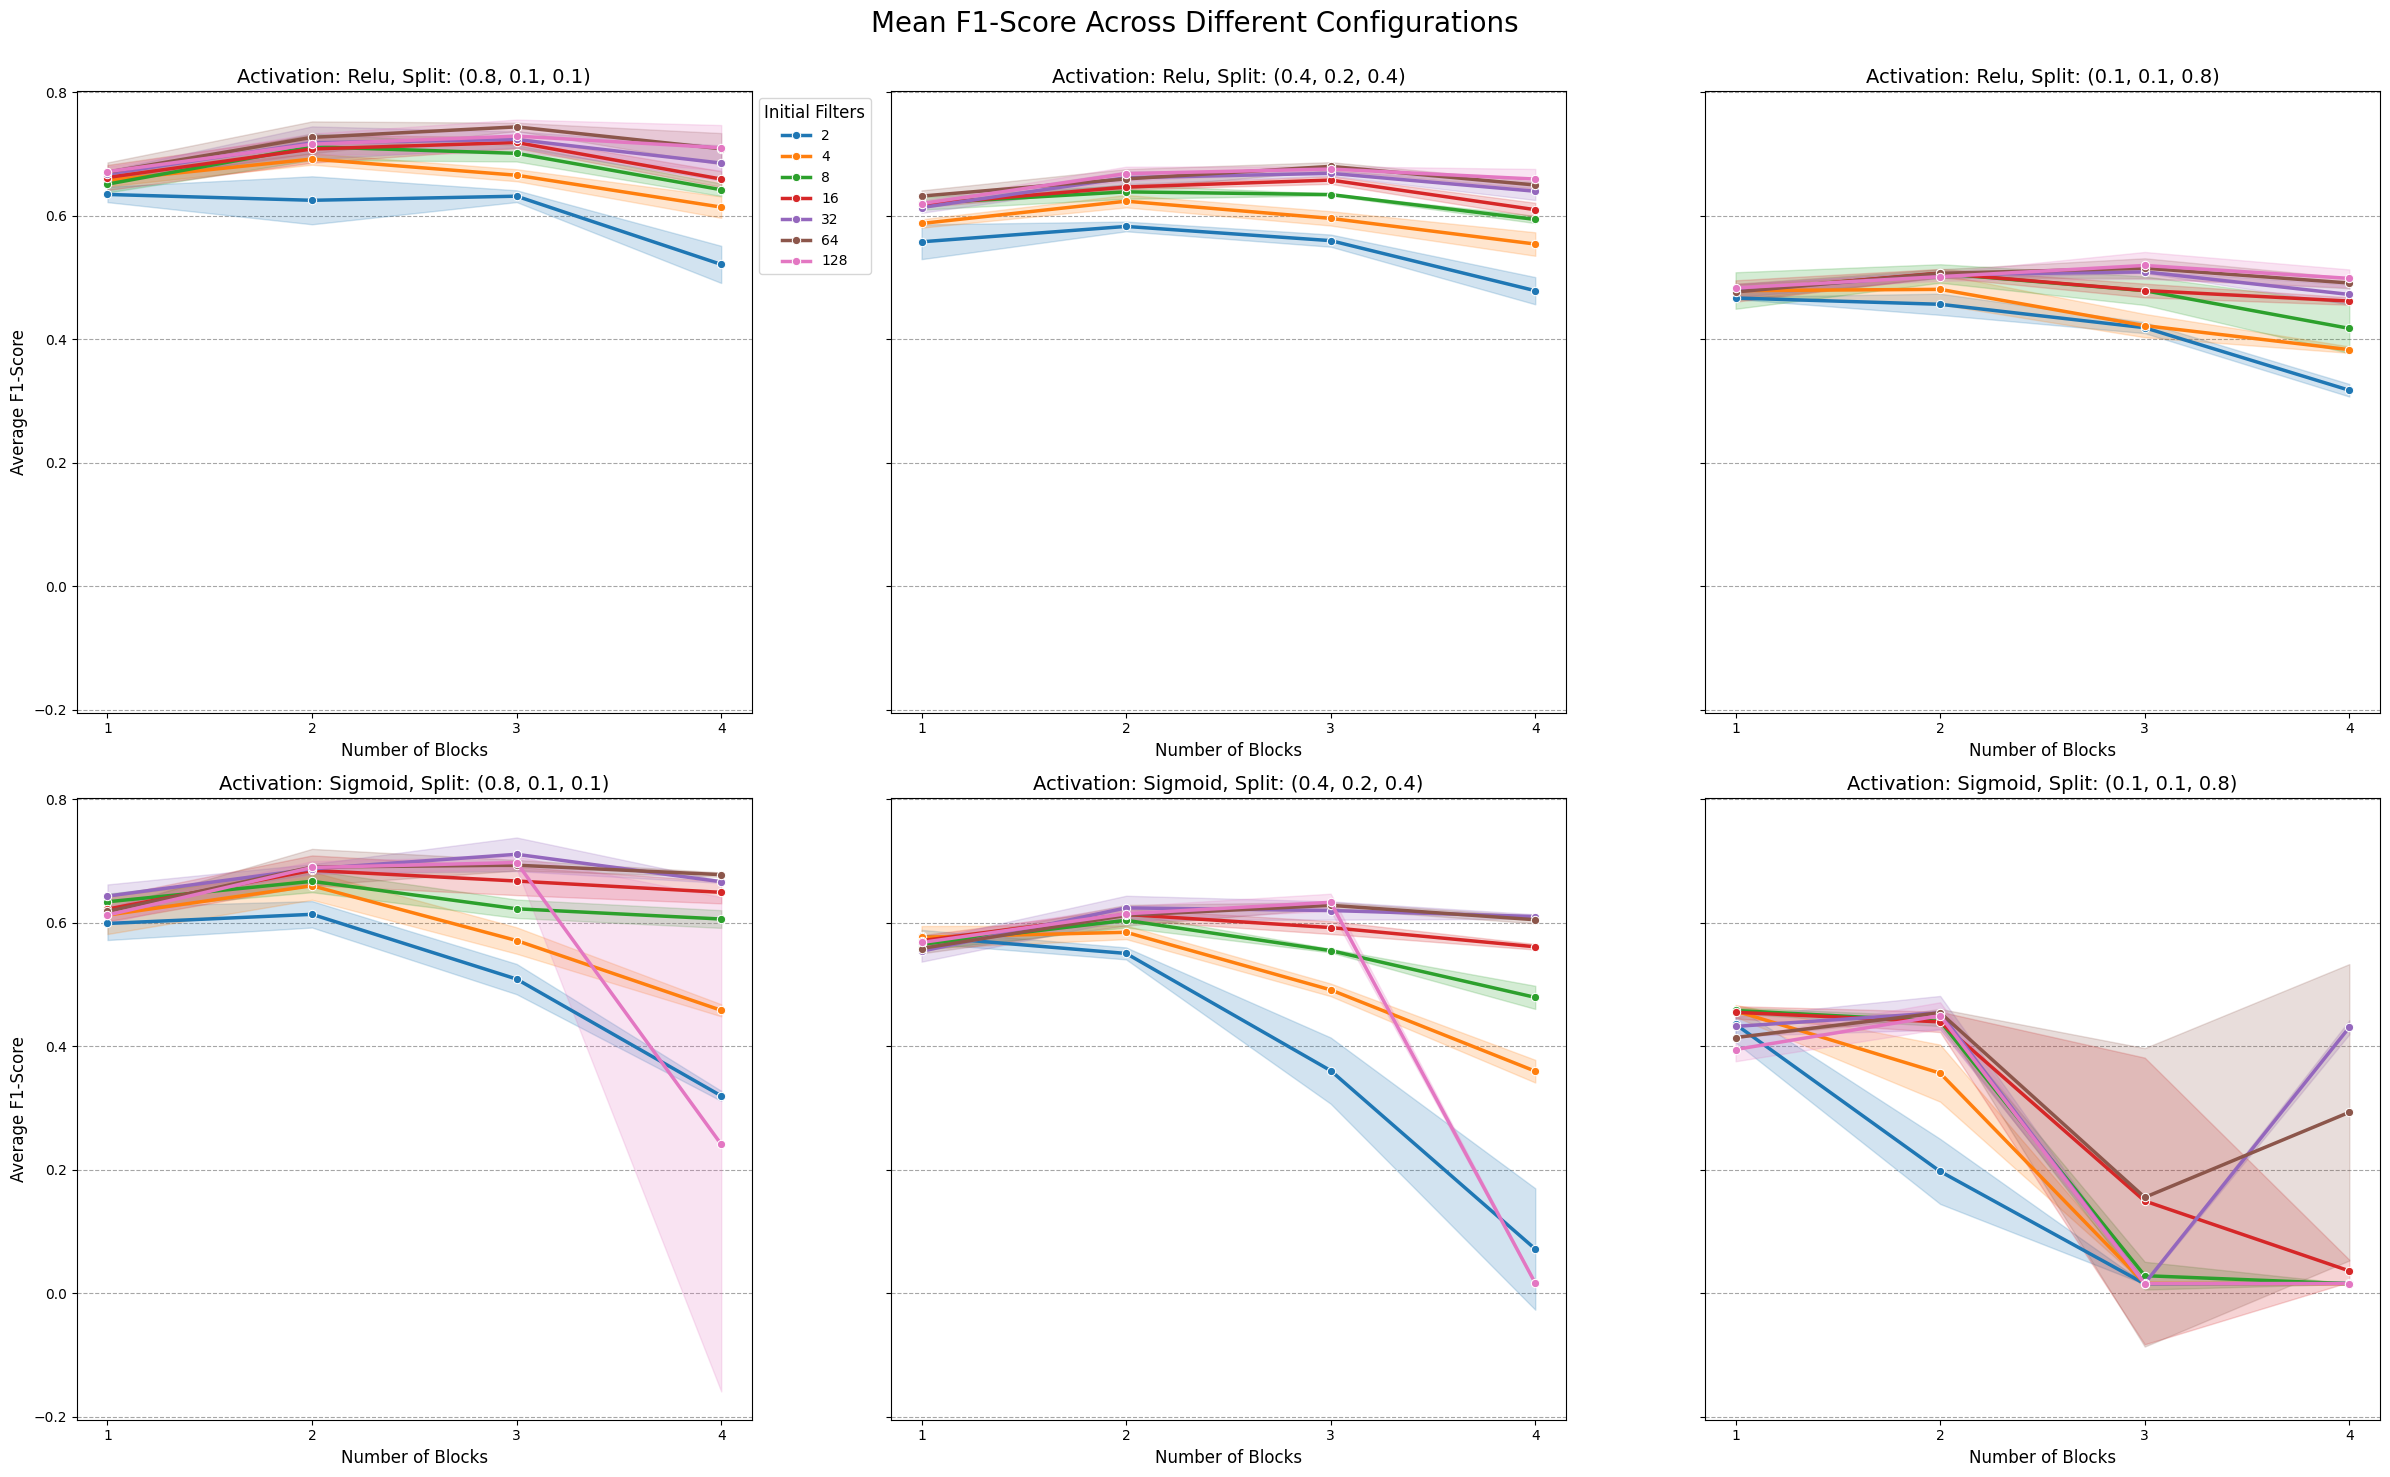

In [25]:
plot_all(
    metric='accuracy', 
    sharey=True,
    # csv_path=os.path.join('results', experiment_filename),
    save_path='results/mean_test_accuracy_grid.png'
)


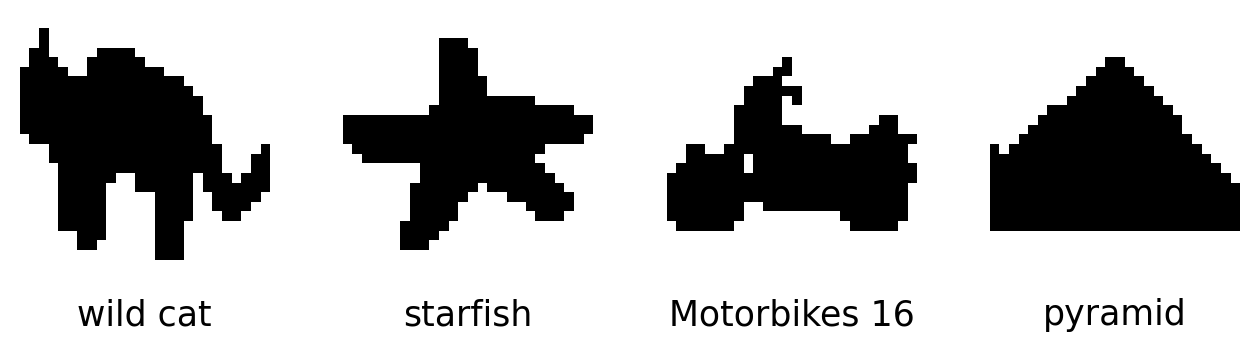

In [100]:
import scipy.io
import torch
import matplotlib.pyplot as plt
import random

mat_file = 'data/caltech101_silhouettes_28.mat'
data = scipy.io.loadmat(mat_file)
X = torch.tensor(data['X'], dtype=torch.float32).reshape(-1, 28, 28)
y = torch.tensor(data['Y'], dtype=torch.long).squeeze() - 1 

labels = [name[0] for name in data['classnames'][0]]

sample_indices = [8505, 7613, 2168]

while len(sample_indices) < 4:
    additional_index = random.choice(range(len(X)))
    if additional_index not in sample_indices:
        sample_indices.append(additional_index)

sample_images = X[sample_indices]
sample_labels = y[sample_indices]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, ax in enumerate(axes):
    ax.imshow(torch.rot90(sample_images[i], k=-1).numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"{labels[sample_labels[i].item()]}", fontsize=25, y=-0.2)


plt.savefig("sample_images_dataset.png", dpi=300)
plt.show()


In [4]:
import scipy.io
import torch
from collections import Counter

mat_file = 'data/caltech101_silhouettes_28.mat'
data = scipy.io.loadmat(mat_file)
y = torch.tensor(data['Y'], dtype=torch.long).squeeze() - 1 

labels = [name[0] for name in data['classnames'][0]]
class_counts = Counter(y.numpy())

print("Number of images per class:")
for idx, count in sorted(class_counts.items()):
    print(f"{labels[idx]}: {count}")


Number of images per class:
Airplanes Side 2: 798
Faces 2: 435
Faces 3: 435
Leopards: 200
Motorbikes 16: 798
accordion: 55
anchor: 42
ant: 42
barrel: 47
bass: 54
beaver: 46
binocular: 33
bonsai: 128
brain: 98
brontosaurus: 43
buddha: 85
butterfly: 91
camera: 49
cannon: 43
car side: 123
ceiling fan: 47
cellphone: 59
chair: 62
chandelier: 107
cougar body: 47
cougar face: 69
crab: 73
crayfish: 70
crocodile: 50
crocodile head: 51
cup: 57
dalmatian: 67
dollar bill: 52
dolphin: 65
dragonfly: 68
electric guitar: 75
elephant: 64
emu: 53
euphonium: 64
ewer: 85
ferry: 67
flamingo: 67
flamingo head: 45
garfield: 34
gerenuk: 34
gramophone: 51
grand piano: 99
hawksbill: 100
headphone: 42
hedgehog: 54
helicopter: 88
ibis: 80
inline skate: 31
joshua tree: 64
kangaroo: 86
ketch: 114
lamp: 61
laptop: 81
llama: 78
lobster: 41
lotus: 66
mandolin: 43
mayfly: 39
menorah: 87
metronome: 32
minaret: 76
nautilus: 55
octopus: 35
okapi: 39
pagoda: 47
panda: 37
pigeon: 45
pizza: 53
platypus: 34
pyramid: 57
revolv

In [11]:
data['X'].shape[0]

8671

In [19]:
size_ds = data['X'].shape[0]
print((33/size_ds)*100)

0.3805789412985815


In [3]:
import pandas as pd

file_path = 'results/experiment_results.csv' 
data = pd.read_csv(file_path)

pearson_corr = data['average_test_accuracy'].corr(data['average_f1_score'], method='pearson')
spearman_corr = data['average_test_accuracy'].corr(data['average_f1_score'], method='spearman')
kendall_corr = data['average_test_accuracy'].corr(data['average_f1_score'], method='kendall')

print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")
print(f"Kendall Correlation: {kendall_corr}")


Pearson Correlation: 0.9987838407679146
Spearman Correlation: 0.9981872653032722
Kendall Correlation: 0.9700923307886196
